Packages à installer

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import romberg
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from datetime import datetime

Définition des classes

In [2]:
class Plant:
    objs = []
    
    def __init__(self, ID_nb, ID_chambre_culture, species):
        Plant.objs.append(self)
        self.ID_nb = ID_nb
        self.ID_chambre_culture = ID_chambre_culture
        self.species = species
        self.Fm = []
        self.Dm = []
        self.Dm_0 = [1*10**(-3) ] #[g]
        self.Dm.append(self.Dm_0)
        self.fresh_matter(self.Dm_0[0]) #[g]
        self.Cout = 0
        
    def dDmdt (self,Dm, t, T, CO2_air, PAR): 
        # #définition des constantes et des paramètres
        c_alpha = 0.68 #[-]
        c_bheta = 0.8 #[-]
        c_bnd = 0.004 #[-]
        c_car1 = -1.32 * 10**(-5) #[m/s.°C²]
        c_car2 = 5.94*10**(-4)#[m/s.°C]
        c_car3 =-2.64*10**(-3)#[m/s]
        c_eps = 17*10**(-9)#[kg/J]
        c_T = 7.32 * 10**(-5)#[kg/m³]
        c_k = 0.9 #[-]
        c_lar_d = 62.5#[m²/kg]
        c_Q10_T = 2 #[-]
        c_Q10_resp = 2 #[-]
        c_resp_s = 3.47*10**(-7)#[s-1]
        c_resp_r = 1.16*10**(-7)#[s-1]
        c_stm = 0.007 #[m/s]
        c_t = 0.07 #[-]
        #calcul de la résistance de la carboxylation [m/s]
        sigma_car = c_car1*T**(2)+c_car2*T+c_car3
        #calcul de la conductance lumineuse de la canopée [m/s]
        sigma_co2 = ((1/c_bnd)+(1/c_stm)+(1/sigma_car))**(-1)      
        #calcul du point de compensation du CO2 [kg/m³]
        Gam = c_T*c_Q10_T**((T-20)/10)
        #Calcul du light use efficiency de la photosynthèse [kg/J]
        eps = c_eps*((CO2_air-Gam)/(CO2_air+2*Gam))
        #calcul du taux maximal d'assimilation photosynthétique [kg/m².s]
        P_max = (eps*PAR*sigma_co2*(CO2_air-Gam))/(eps*PAR+sigma_co2*(CO2_air-Gam))
        #calcul du taux de respiration [kg/m².s]
        R = (c_resp_s *(1-c_t)+ c_resp_r*c_t)* Dm*c_Q10_resp**(0.1*T - 2.5)
        #calcul du taux d'assimilation photosynthétique [kg/m².s]
        P = P_max *(1-np.exp(-c_k*c_lar_d*(1-c_t)*Dm))
        #calcul de la dérivée de la masse sèche d'une plante au cours du temps [kg/s]
        dDmdt = c_bheta *(c_alpha * P - R)/18 #18 est le nombre de plante par m² implémenté dans le modèle utilisé
        return dDmdt
    
    def fresh_matter (self,Dm):
        #calcul de la masse de matière fraiche d'une laitue [kg/m²] en fonction de sa matière sèche    
        c_fw = 22.5#[-]
        c_t = 0.07 #[-]
        Fm = c_fw*Dm*(1-c_t)
        self.Fm.append(Fm)
    
    def dry_matter (self, Dm_0, dt, PAR, T, CO2_air):
        
        tspan=[0,dt*60]
        Dm_cur = odeint (self.dDmdt, Dm_0, tspan, args= (T, CO2_air, PAR, ) )
        Dm = Dm_cur[-1]
        self.Dm.append(Dm)
    
    def Cost (self, prix, dt, conso_plante_unitaire):
        self.Cout += (prix/100)*(conso_plante_unitaire/1000)*(dt/60)
    
class chambre_culture:
    objs=[]
    
    def __init__(self, ID_nb, surface, nb_LED, nb_plantes, CO2_air, temperature):
        chambre_culture.objs.append(self)
        self.ID_nb = ID_nb
        self.surface = surface #[m²]
        self.nb_LED = nb_LED
        self.nb_plantes = nb_plantes
        self.CO2_air = CO2_air
        self.temperature = temperature
    
    @classmethod
    def link_objects (cls):
        for chambre_culture in cls.objs :
            for scenario in Scenario.objs :
                if chambre_culture.ID_nb == scenario.ID_chambre_culture:
                    chambre_culture.Scenario = scenario
            for led in LED.objs :
                if chambre_culture.ID_nb == led.ID_chambre_culture:
                    chambre_culture.LED = led
                    led.Scenario = chambre_culture.Scenario
                    led.Chambre_culture = chambre_culture
            for plant in Plant.objs :
                if chambre_culture.ID_nb == plant.ID_chambre_culture:
                    chambre_culture.plant = plant
                    plant.chambre_culture = chambre_culture
            for alim in Alim.objs :
                if chambre_culture.ID_nb == alim.ID_chambre_culture:
                    chambre_culture.alim = alim        
                    
    @classmethod 
    def resol_step  (cls, prix_cour, PPFD_voulu):
        for room in cls.objs :
            room.conso = (room.nb_LED * room.LED.conso)/room.alim.rendement
            room.conso_plante_unitaire =  room.conso / room.nb_plantes
            room.PAR = room.nb_LED * room.LED.PAR_emis
            room.plant.Cost(prix_cour, room.Scenario.pas_de_temps, room.conso_plante_unitaire)
            room.plant.dry_matter(room.plant.Dm[-1],room.Scenario.pas_de_temps,room.PAR, room.temperature, room.CO2_air)
            room.plant.fresh_matter(room.plant.Dm[-1])
        
class Scenario: 
    objs=[]
    
    def __init__(self,ID_nb, ID_chambre_culture, nb_jour, pas_de_temps, heure_debut, photoperiode):
        Scenario.objs.append(self)
        self.ID_nb =ID_nb
        self.nb_jour = nb_jour
        self.pas_de_temps = pas_de_temps
        self.heure_debut=heure_debut #durée du scénario en heure 
        self.photoperiode= photoperiode #photopériode en heure
        self.ID_chambre_culture = ID_chambre_culture
    
class LED:
    objs=[]
    
    def __init__(self, ID_nb, ID_chambre_culture,umol_nom,PAR700_nom):
        LED.objs.append(self)
        self.ID_nb = ID_nb
        self.ID_chambre_culture = ID_chambre_culture
        self.umol_nom = umol_nom
        self.PAR700_nom=PAR700_nom
        self.switch = False
        dat_flux_I = pd.read_csv('LED/PAR_I.csv',delimiter = ';', header = 0, decimal = ',') 
        self.I_flux = interp1d (dat_flux_I.iloc[:,1], dat_flux_I.iloc[:,0], kind = 'cubic')
        dat_I_V_P = pd.read_csv('LED/I_voltage.csv',delimiter = ';', header = 0, decimal = ',') 
        self.P_I = interp1d (dat_I_V_P.iloc[:,1], dat_I_V_P.iloc[:,2], kind = 'cubic')
    
    @classmethod 
    def calc_PAR_Puissance_rendement (cls,PPFD_voulu, heure): 
        for led in LED.objs:
            if (heure > led.Scenario.heure_debut and heure < led.Scenario.heure_debut + led.Scenario.photoperiode) or (led.Scenario.heure_debut +led.Scenario.photoperiode > 24 and heure < (led.Scenario.heure_debut +led.Scenario.photoperiode-24)):
                led.switch = True
            else :
                led.switch = False
            flux = (PPFD_voulu*led.Chambre_culture.surface)/(led.umol_nom * led.Chambre_culture.nb_LED) 
            I_voulu = led.I_flux(flux)
            led.conso= led.P_I(I_voulu)*led.switch
            led.PAR_emis= led.PAR700_nom * flux*led.switch

class Alim:
    objs=[]
    
    def __init__(self, ID_nb, ID_chambre_culture, rendement):
        Alim.objs.append(self)
        self.ID_nb = ID_nb
        self.ID_chambre_culture = ID_chambre_culture
        self.rendement = rendement

Défintion d'une fonction calculant les paramètres des LED

In [3]:
def calc_LED ():
    #importation de la courbe spectrale du nombre relatif de photons émis en fonctions de la longueur d'onde
    #création d'une courbe d'interpolation 
    #calcul du nombre de photons émis en intégrant la courbe d'émission spectrale 
    #nombre de photons obtenus = nombre de photons émis par un LED ayant un pic d'émissions d'1 µmol à 630nm
    data_spec_phot_flux = pd.read_csv('LED/spectral_photon_flux.csv',delimiter = ';', header = 0, decimal = ',')
    spec_phot_flux = interp1d (data_spec_phot_flux.iloc[:,0], data_spec_phot_flux.iloc[:,2], kind = 'cubic')
    I= romberg(spec_phot_flux,400,780, divmax = 20)
    #calcul du nombre de photons émis par le LED pour un courant de 700mA 
    nb_lumen_umol = 52.56 #[lumen/umol photon/s] intensité lumineuse d'1 µmol de photons
    intensite_lumineuse_led = 192 #[lumen] intensité lumineuse à 700mA
    umol_led = intensite_lumineuse_led/nb_lumen_umol #[µmol de photon/s] quantité de photons émis par seconde
    #Calcul du nombre de photons émis par 1 LED à 700mA    
    f = umol_led/I #rapport entre la quantité émise par l'ampoule LED considérée et celle émise par l'ampoule standard
    Na = 6.022 * 10**(23)#[entité par mol] nombre d'AVOGADRO
    phot_emis= data_spec_phot_flux.iloc [:,2]*f*Na*10**(-6) #courbe donnant le nombre de photons émis par la LED en fonction de la longeur d'onde
    #calcul de l'énergie d'irradiance de chaque photons émis
    h = 6.63*10**(-34) #constante de Planck [J.s]
    c = 3*10**(8) #vitesse de la lumière [m/s]
    #création d'une courbe donnant l'énergie d'irradiance émise par la LED en fonction de la longueur d'onde
    en_emis=[]
    for i in np.arange (len(data_spec_phot_flux.iloc[:,0])):
        en_emis.append ((phot_emis [i]*h*c)/(data_spec_phot_flux.iloc[i,0]*10**(-9)))
    en_emis_lambda = interp1d (data_spec_phot_flux.iloc[:,0],en_emis,kind ='cubic')
    #calcul du rayonnement photosynthétiquement actif [W] en intégrant cette courb entre 400 et 700nm  
    PAR = romberg (en_emis_lambda,400,700, divmax = 20)
    #on renvoie  le nombre de umol émis par seconde et le PAR émis par seconde
    return umol_led,PAR

Définition d'une fonction ajustant la quantité de photons envoyés aux plantes au prix de l'électricité

In [4]:
def ajust_conso(prix ,prix_max , prix_min, PPFD_max, PPFD_min):
    m = (PPFD_min - PPFD_max)/(prix_max-prix_min)
    p = PPFD_max-m*prix_min
    PPFD= m*prix + p
    return PPFD

# def ajust_conso(prix ,prix_max , prix_min, PPFD_max, PPFD_min):
#    PPFD= 300
#    return PPFD

Défintion des paramètres des objets constituants le système

In [5]:
#paramètres chambre de culture 
temperature = 23 #[°C]
CO2_air = 5*10**(-2) #[kg/m³]
nb_led_room = 65 #nombre de LED dans une chambre de culture
nb_plante_room = 20 # nombre de plante dans la chambre de culture
surface = 1 #m² 

#paramètres alimentation 
rendement_alim = 0.85

#paramètres scenario
nb_jour = 42
pas_de_temps = 15 #minutes
heure_debut = 20
photoperiode = 16 #h 
periode_regulation = 'journée'

#paramètres LED
[umol700_nom,PAR700_nom] = calc_LED()

Création des objets du système sur base des paramètres sélectionnés

In [6]:
lettuce_1= Plant(1,1,'lettuce')
chambre_culture_1= chambre_culture(1,1,nb_led_room,nb_plante_room,CO2_air,temperature)
aLED_1 =LED(1,1,umol700_nom,PAR700_nom)
alim_1 = Alim(1,1,rendement_alim)
scenario_1 =Scenario (1,1,nb_jour,pas_de_temps,heure_debut,photoperiode)

chambre_culture.link_objects()

Importation des données de prix de l'électricité

In [7]:
prix = pd.read_csv('prix_elec/DA prices BE NL 2018-2019.csv', delimiter = ';' ,header = 0)
prix.iloc[:,0] =pd.to_datetime(prix.iloc[:,0])

Initialisation de la simulation

In [8]:
periode_regulation = 'journée'
if periode_regulation =='journée':
    n = (24*4)-1
elif periode_regulation =='semaine':
    n = (7*24*4)-1
elif periode_regulation =='mois':
    n = (30*24*4)-1
prix_last_day = prix.iloc[0:n,5]
prix_min = min(prix_last_day)
prix_max = max(prix_last_day)
PPFD_min = 100#[µmol photons]
PPFD_max = 500#[µmol photons]
first_in = 0

Simulation de la croissance et du cout des plantes sur la période considérée

In [9]:
for j in np.arange(nb_jour*24*4):
    prix_cour = prix.iat[j,5]
    prix_last_day [first_in] = prix_cour
    prix_min = min(prix_last_day)
    prix_max = max(prix_last_day)   
    if first_in == len(prix_last_day):
        first_in = 0
    else:
        first_in +=1        
    PPFD_voulu = ajust_conso(prix_cour ,prix_max , prix_min, PPFD_max, PPFD_min)
    heure = prix.iat[j,0].hour
    
    LED.calc_PAR_Puissance_rendement(PPFD_voulu,heure)
    chambre_culture.resol_step(prix_cour, PPFD_voulu)

Représentation graphique des résultats obtenus 

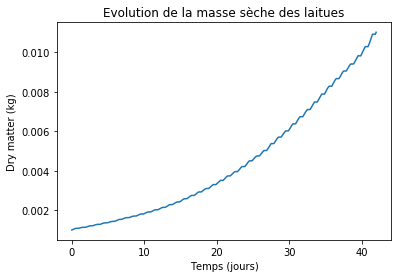

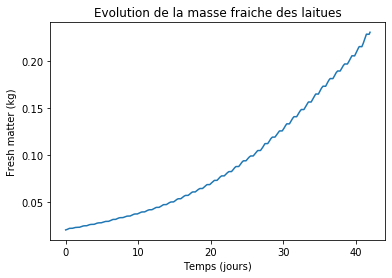

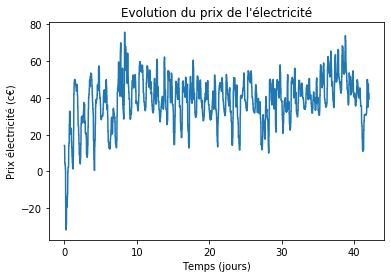

In [10]:
plt.plot(np.arange(len(lettuce_1.Dm[:]))/(24*4),lettuce_1.Dm[:])
plt.xlabel('Temps (jours)')
plt.ylabel('Dry matter (kg)')
plt.title ('Evolution de la masse sèche des laitues')
plt.show()
plt.plot(np.arange(len(lettuce_1.Dm[:]))/(24*4),lettuce_1.Fm[:])
plt.xlabel('Temps (jours)')
plt.ylabel('Fresh matter (kg)')
plt.title ('Evolution de la masse fraiche des laitues')
plt.show()
plt.plot(np.arange(len(lettuce_1.Dm[:]))/(24*4),prix.iloc[0:((nb_jour*24*4)+1),5])
plt.xlabel('Temps (jours)')
plt.ylabel('Prix électricité (c€)')
plt.title ("Evolution du prix de l'électricité")
plt.show()